In [ ]:

%load_ext autoreload
%autoreload 2


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#RUN BEFORE#

In [3]:
#RUN AFTER#

import hls4ml
import pickle
import plotting as pl

from util.Models import *
from util.Generators import *
from util.Plotting import *


/home/joshualerner/.local/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [4]:

data_path = '/fast_scratch_1/atlas_images/v01-45/'

cell_geo_path = data_path + 'cell_geo.root'

out_path = '/fast_scratch_1/jlerner/data/'

norm = 'log' # 'log', 'std', or 'max'
scaler = None

In [5]:

model = tf.keras.models.load_model(out_path + 'models/GarNet_' + norm, 
                                   custom_objects={"GarNetModel": GarNetModel}, compile=False)

with open(out_path + 'models/GarNet_' + norm + '/history.pickle', "rb") as file:
    history = pickle.load(file)

if norm != 'log':
    with open(out_path + 'models/GarNet_' + norm + '/scaler.pickle', 'rb') as file:
        scaler = pickle.load(file)


2023-06-13 15:48:46.049888: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-13 15:48:46.049964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6609 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [6]:

test_file_list = ([[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] for i in range(232, 264)],
                  [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] for i in range(232, 264)])

test_generator = garnetDataGenerator(test_file_list,
                                     cell_geo_path,
                                     batch_size=20000,
                                     normalizer=(norm, scaler),
                                     name='garnet_' + norm,
                                     labeled=True,
                                     preprocess=False,
                                     output_dir=out_path + 'test/')

x, y = next(test_generator.generator())

In [7]:

config = hls4ml.utils.config_from_keras_model(model, granularity='model')

print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 4]], output shape: [None, 128, 4]
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: garnet, layer type: GarNetStack, input shapes: [[None, 128, 4], [None, 1]], output shape: [None, 16]
Layer name: dense, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 8]
Layer name: classification, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 2]
Layer name: regression, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 1]
-----------------------------------
Configuration
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
-----------------------------------


In [8]:

hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, 
                                                       output_dir='/home/joshualerner/start_tf/PionReconstruction/data/', 
                                                       part='xcku115-flvb2104-2-i')

#hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 4]], output shape: [None, 128, 4]
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: garnet, layer type: GarNetStack, input shapes: [[None, 128, 4], [None, 1]], output shape: [None, 16]
Layer name: dense, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 8]
Layer name: classification, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 2]
Layer name: regression, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 1]
Creating HLS model


In [9]:
hls_model.compile()

keras_pred = model.predict(x)
hls_pred = hls_model.predict(x)

Writing HLS project
Done


2023-06-13 15:49:04.911325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


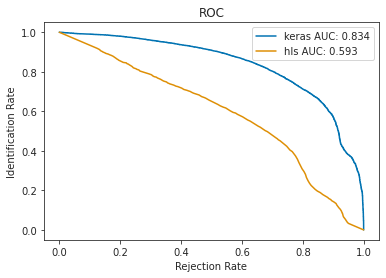

In [10]:
ROC = Plotter(roc, 
              preds=[keras_pred[0][:,0], hls_pred[0][:,0]], 
              targets=[y['classification'][:,0], y['classification'][:,0]],
              labels=['keras', 'hls'])
ROC.show()

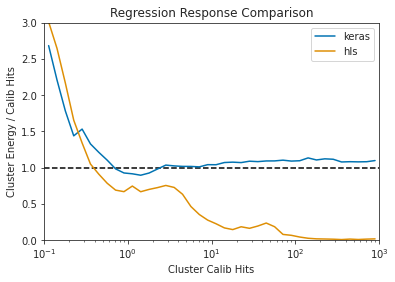

In [11]:
if norm == 'log':
    keras_scaled_pred = np.exp(keras_pred[-1]).reshape(-1,)
    hls_scaled_pred = np.exp(hls_pred[-1]).reshape(-1,)
    scaled_target = np.exp(y['regression']).reshape(-1,)
else:
    keras_scaled_pred = scaler.inverse_transform(keras_pred[-1]).reshape(-1,)
    hls_scaled_pred = scaler.inverse_transform(hls_pred[-1]).reshape(-1,)
    scaled_target = scaler.inverse_transform(np.reshape(y['regression'], (-1, 1))).reshape(-1,)

reg = Plotter(regResponseOverlay, 
              preds=[keras_scaled_pred, hls_scaled_pred], 
              targets=[scaled_target, scaled_target],
              labels=['keras', 'hls'])
reg.show()